# COVID-19 Dashboard Updates
Center for Human Dynamics in the Mobile Age (HDMA) at San Diego State University

Jessica Embury

### MODULES

In [11]:
#import modules
import arcgis
from arcgis.gis import GIS
from arcgis import geometry
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.features import FeatureLayerCollection
from arcgis.features import FeatureLayer
from arcgis.mapping import WebMap
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import json
from copy import deepcopy
import time
import numpy as np
import sys
import webbrowser
from copy import deepcopy

### CONFIRM USER VARIABLES BEFORE RUNNING CELLS

In [10]:
##########################
###SET PATHS IN AND OUT###
##########################
#PATHS IN
#additional needed zip info - community name and population
zips_info_path = ''

#PATHS OUT
#wide df with a column for each date
wide_df_path = ''

#path out for dash updates, feature layer overwrite
path_out= ''

#path to csv used to append new column to feature layer 2 for cumulative cases dashboard
append_csv_path = ''

#upload to dropbox
dropbox_cumulative = ''

######################################
###ARCGIS ACCOUNT LOGIN INFORMATION###
######################################

#reference for authentication schemes: https://developers.arcgis.com/python/guide/working-with-different-authentication-schemes/

#portal =''
#username=''
#password=''

pro = "pro"

################################
###ARCGIS DETAILS FOR UPDATES###
################################
#URL TO SD COUNTY'S COVID-19 FEATURE SERVICE
sd_dashboard_service = 'https://services1.arcgis.com/1vIhDJwtG5eNmiqX/ArcGIS/rest/services/CovidDashUpdate/FeatureServer'

#feature layer ID to overwrite
feature_layer = "65333d10997d4eb7bf921e11472ae35d"
feature_layer2 = '2a2645b5f569461d916122c3e16d96f3'

#csv to append to feature_layer2
append_csv = '49be034d6b7a406ca291cb44e94e1be1'

#map IDs for symbology update
#heatmaps
hm1 = "3bb63e3ff08243cebf465919191863a0"
hm2 = "2c8a7e1fe2114bfea6317ae4c3268514"

#rates maps
rc1 = "81ff6fce8f7840f8818ae1651db49fc7"
rc2 = "f0d7afc488ae4d048c2413159ab70921"
rc3 = "a24f481d8e954411a40d6b9a18465f86"
rc4 = "a9fe5732f5ac4ac395f66bdd2275d2ec"

#confirmed cases map
cc = "146c49a7148944c09dd18eccf6036e46"

#urls for dashboards (to verify)
heatmap_dash = 'https://arcg.is/1br8v9'
rates_dash = 'https://arcg.is/0Gy0mj'
cumulative_dash = 'https://arcg.is/1zXq1m'
cumulative_mobile = 'https://arcg.is/1WLnjG'

### CONNECT TO ARCGIS ACCOUNT
Reference for authentication schemes: https://developers.arcgis.com/python/guide/working-with-different-authentication-schemes/

In [12]:
gis = GIS(pro)

#gis = GIS(portal, username, password)

### COLLECT AND FORMAT COVID-19 DATA FROM SD COUNTY'S FEATURE SERVICE

In [14]:
#Retrieve the current layer from SDCounty dashboard, convert to a DF, convert to 4326, and transform to a DF by zip codes (using Pivot), resulting in a wide table
db_item = FeatureLayerCollection(sd_dashboard_service)

# convert the layer with counts by zips into a df, in 4326
raw = db_item.layers[0].query(out_sr = 4326, return_geometry=True).sdf

# create the Lat and Lon columns in this df.
raw['Latitude'] = np.nan
raw['Longitude'] = np.nan

for i, row in raw.iterrows():
    temp = raw['SHAPE'][i]
    lat = temp['y']
    lon = temp['x']
    raw['Latitude'][i] = lat
    raw['Longitude'][i] = lon
    
# generate better time stamps
raw['Date'] = raw['UpdateDate']
raw['Date'] = raw['Date'].dt.strftime("%m/%d/%y")
raw = raw.drop_duplicates(['ZipText','Date'])
    
# generate a wide table for the current file, with a column for every date
wide_df = raw.pivot(index='ZipText', columns='Date', values='Case_Count')
wide_df['Zipcode'] = wide_df.index

#GET CURRENT DATE FOR EXPORTED CSVs, CASE RATE AND INCREASE CALCULATIONS
least_recent_date = raw['UpdateDate'].min()
least_recent_date = least_recent_date.strftime("%m/%d/%y")
most_recent_date = raw['UpdateDate'].max()
most_recent_date = most_recent_date.strftime("%m/%d/%y")
print(most_recent_date)

#output wide table as CSV for records
wide_df.to_csv(wide_df_path.format(most_recent_date.replace('/', '')))

wide = pd.read_csv(wide_df_path.format(most_recent_date.replace('/', '')))

#convert zipcode column to string type
for i, row in wide.iterrows():
    temp = str(wide['Zipcode'][i])
    wide['Zipcode'][i] = temp
    
del wide['ZipText'] 

08/16/20


In [15]:
#format and export wide df to dropbox
wide_dropbox = wide['Zipcode'].reset_index()
wide_dropbox = wide_dropbox.merge(wide, on = 'Zipcode')
wide_dropbox = wide_dropbox.fillna(0)
wide_dropbox = wide_dropbox.query('Zipcode > 0')
wide_dropbox = wide_dropbox.astype(int)
del wide_dropbox['index']
del wide_dropbox['Unnamed: 1']
wide_dropbox.to_csv(dropbox_cumulative.format(most_recent_date.replace('/','')), index=False)
wide_dropbox

,Zipcode,03/30/20,03/31/20,04/01/20,04/02/20,04/03/20,04/04/20,04/05/20,04/06/20,04/07/20,04/08/20,04/09/20,04/10/20,04/11/20,04/12/20,04/13/20,04/14/20,04/15/20,04/16/20,04/17/20,04/18/20,04/19/20,04/20/20,04/21/20,04/22/20,04/23/20,04/24/20,04/25/20,04/26/20,04/27/20,04/28/20,04/29/20,04/30/20,05/01/20,05/02/20,05/03/20,05/04/20,05/05/20,05/06/20,05/07/20,...,07/08/20,07/09/20,07/10/20,07/11/20,07/12/20,07/13/20,07/14/20,07/15/20,07/16/20,07/17/20,07/18/20,07/19/20,07/20/20,07/21/20,07/22/20,07/23/20,07/24/20,07/25/20,07/26/20,07/27/20,07/28/20,07/29/20,07/30/20,07/31/20,08/01/20,08/02/20,08/03/20,08/04/20,08/05/20,08/06/20,08/07/20,08/08/20,08/09/20,08/10/20,08/11/20,08/12/20,08/13/20,08/14/20,08/15/20,08/16/20
1,91901,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,...,42,45,46,48,48,48,49,49,50,50,53,53,54,55,55,56,57,60,62,66,67,68,72,78,78,79,79,80,80,80,80,80,82,83,83,84,84,84,84,84
2,91902,8,8,9,10,10,11,11,14,16,16,16,16,17,17,16,17,17,18,18,18,18,22,23,23,23,24,26,27,28,28,30,30,30,30,31,32,32,33,33,...,104,104,108,113,114,117,121,123,125,130,134,135,138,140,143,144,149,152,154,155,158,160,165,169,171,171,173,177,178,182,186,188,190,190,190,191,192,196,195,199
3,91905,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,4,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7,7
4,91906,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,9,10,10,11,11,11,11,12,13,13,13,13,14,14,14,14,15,15,15,16,16,16,16,16,16,16,16,16,16,16,16,17,17,17,17,17,17,17,17,17
5,91910,17,21,23,28,28,30,30,34,39,43,44,48,48,52,57,61,66,66,68,68,70,73,75,87,100,107,115,116,120,124,135,143,148,155,162,186,194,203,209,...,784,793,805,821,835,857,876,891,918,945,970,983,984,1014,1035,1058,1097,1111,1133,1155,1164,1179,1200,1223,1243,1259,1272,1287,1306,1335,1343,1365,1374,1381,1396,1412,1427,1433,1446,1457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,92173,5,7,8,12,13,17,17,18,20,21,23,25,26,28,32,36,39,43,47,52,59,66,69,74,81,83,90,94,98,102,109,114,123,127,131,135,137,142,158,...,624,630,642,651,659,666,672,680,696,710,724,740,744,767,791,820,849,860,893,912,923,936,945,965,974,977,988,999,1007,1024,1037,1055,1066,1069,1076,1083,1096,1108,1125,1139
110,92182,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
111,92259,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112,92536,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


### ASSIGN ZIP COORDS TO DF FOR LATER USE

In [16]:
#COORDS
#get set of zip code coordinates to add to update df
coords = raw[['ZipText', 'Latitude', 'Longitude']]
coords = coords.rename(columns={'ZipText':'Zipcode'})
coords = coords.drop_duplicates(['Zipcode'])

#convert zipcode column to numeric for merging
coords['Zipcode'] = pd.to_numeric(coords['Zipcode'])

### MERGE WIDE DF WITH COORDINATES DF AND COMMUNITY/POPULATION CSV DATA
### SUBSET DF WITH ONLY COLUMNS FOR HDMA RATES/PERCENTS FEATURE LAYER

In [17]:
#import additional needed zip info
zips_info = pd.read_csv(zips_info_path)

for i, row in zips_info.iterrows():
    temp = str(zips_info['Zipcode'][i])
    zips_info['Zipcode'][i] = temp

#merge with coords to add lat and lon
zips_info = zips_info.merge(coords, on="Zipcode")

#merge wide df with coords and extra zip code info
wide = wide.merge(zips_info, on="Zipcode")

#create new df for use feature layer overwrite
cols = ['Zipcode', 'Community', 'Latitude', 'Longitude', '2018_population']
df = wide[cols]

df['Date'] = most_recent_date

df['Confirmed Cases'] = wide[most_recent_date]
df['Confirmed Cases'] = df['Confirmed Cases'].fillna(0)
df['Confirmed Cases'] = df['Confirmed Cases'].astype(int)

df['Rate Per 100K'] = (df['Confirmed Cases']/df['2018_population']*100000).round(2)

df = df.fillna(0)

### TEMPORARY DF TO CALCULATE CASE INCREASE AND RATES OF CHANGE, MERGE TO MAIN DF

In [18]:
#CREATE DF
date_df = wide[['Zipcode', wide.columns[-13], wide.columns[-12], wide.columns[-11], wide.columns[-10], wide.columns[-9], wide.columns[-8], wide.columns[-7], wide.columns[-6]]]
date_df = date_df.fillna(0)
#date_df.head()

#CREATE COLUMN FOR CASE INCREASES AND CALCULATE
date_df['Daily Increased'] = 0

for i, row in date_df.iterrows():
    day1 = int(date_df.iloc[:,-2][i])
    day2 = int(date_df.iloc[:,-3][i])
    date_df['Daily Increased'][i] = (day1-day2)

#CREATE COLUMN FOR DAILY CHANGE RATE AND CALCULATE
date_df['Daily Change Rate*1000'] = 0.0

for i, row in date_df.iterrows():
    day1 = int(date_df.iloc[:,-3][i])
    day2 = int(date_df.iloc[:,-4][i])
    if(day2 != 0):
        date_df['Daily Change Rate*1000'][i] = round(((day1 - day2)/day2)*1000, 2)

#CREATE COLUMN FOR 7 DAY ROLLING RATE OF CHANGE AND CALCULATE
date_df['7 Days Rolling Change*1000'] = 0.0

rolling_rate_day_list_cols = [[-4,-5],[-5,-6],[-6,-7],[-7,-8],[-8,-9],[-9,-10],[-10,-11]]

for i, row in date_df.iterrows():
    all_days=0
    
    for x in range(len(rolling_rate_day_list_cols)):
        day1 = int(date_df.iloc[:,rolling_rate_day_list_cols[x][0]][i])
        day2 = int(date_df.iloc[:,rolling_rate_day_list_cols[x][1]][i])

        if(day2 != 0):
            one_day = ((day1 - day2)/day2)*1000
            all_days = all_days + one_day
           
    date_df['7 Days Rolling Change*1000'][i] = round(all_days/len(rolling_rate_day_list_cols), 2)

#MERGE NEW COLUMNS WITH MAIN DF
date_df_subset = date_df[['Zipcode', 'Daily Increased', 'Daily Change Rate*1000', '7 Days Rolling Change*1000']]

df =df.merge(date_df_subset, on='Zipcode')
#print(len(df))
#df.head()

#SUBSET DATA TO POPULATION >= 5000 AND CONFIRMED CASES >= 10
df = df[df['2018_population'] >= 5000]
df = df[df['Confirmed Cases'] >= 10]
#print(len(df))
#df.head()

### CALCULATE NEW/CUMULATIVE CASE PERCENTS

In [19]:
#get cumulative case and daily increase totals for county
sum_confirmed = 0
sum_daily = 0

for i, row in df.iterrows():
    sum_confirmed = sum_confirmed + df['Confirmed Cases'][i]
    sum_daily = sum_daily + df['Daily Increased'][i]
    
#add new columns and calculate percent of total and percent of daily new for each zip code
df['percent_total'] = (df['Confirmed Cases']/sum_confirmed)*100
df['percent_daily'] = (df['Daily Increased']/sum_daily)*100

#round columns to 2 decimal places
df['percent_total'] = df['percent_total'].round(2)
df['percent_daily'] = df['percent_daily'].round(2)

#no decimals for zipcode column
df['Zipcode'] = df['Zipcode'].apply(np.int64)

### OUTPUT CSV FOR RECORDS

In [20]:
#save as csv files
df.to_csv(path_out, index = False) 
df.head()

,Zipcode,Community,Latitude,Longitude,2018_population,Date,Confirmed Cases,Rate Per 100K,Daily Increased,Daily Change Rate*1000,7 Days Rolling Change*1000,percent_total,percent_daily
0,91901,Alpine,32.805710,-116.695537,17885,08/16/20,84,469.67,0,0.00,3.46,0.25,0.00
1,91902,Bonita,32.671583,-117.015068,17375,08/16/20,199,1145.32,4,20.51,6.68,0.59,1.45
4,91910,Chula Vista,32.636413,-117.065653,82682,08/16/20,1457,1762.17,11,7.61,8.42,4.32,4.00
5,91911,Chula Vista,32.607309,-117.050214,84626,08/16/20,1730,2044.29,17,9.92,7.67,5.13,6.18
6,91913,Chula Vista,32.616267,-116.987495,49519,08/16/20,645,1302.53,9,14.15,9.21,1.91,3.27


# UPDATE MAP SYMBOLOGY FOR RATES AND HEATMAP DASHBOARDS

Reference: https://community.esri.com/groups/arcgis-python-api/blog/2019/04/09/updating-layer-symbology-with-the-arcgis-api-for-python

### FEATURE LAYER OVERWRITE

In [21]:
#get feature layer containing updated data for maps associated with the COVID-19 dashboards
layer = gis.content.get(feature_layer)
layer

layer_collection = FeatureLayerCollection.fromitem(layer)

#call the overwrite() method which can be accessed using the manager property
layer_collection.manager.overwrite(path_out)

{'success': True}

### FUNCTIONS

In [22]:
def get_map (map_id):
    '''
    GET MAP DATA FOR SYMBOLOGY CHANGES
    '''
    
    m = gis.content.get(map_id)

    data = m.get_data()
    
    #Include the below line for prettified JSON
    #print(json.dumps(data, indent=4, sort_keys=True))

    print(m)
    
    return data
    
def update_map (map_id, data):
    '''
    UPDATE MAP TO SAVE CHANGES
    '''
    m = gis.content.get(map_id)
    
    # Set the item_properties to include the desired update
    properties = {"text": json.dumps(data)}

    # 'Commit' the updates to the Item
    update = m.update(item_properties=properties)
    
    return update

### FIND MAX/MIN VALUES FOR MAP SYMBOLOGY CHANGES

In [23]:
max_confirmed = df['Confirmed Cases'].max()

max_increased = df['Daily Increased'].max()
max_decreased = 0 - max_increased

min_rate100k = df['Rate Per 100K'].min()
max_rate100k = df['Rate Per 100K'].max()

min_7dayrate = df['7 Days Rolling Change*1000'].min()
max_7dayrate = df['7 Days Rolling Change*1000'].max()

### RATES OF CHANGE DASHBOARD

In [24]:
#rates map1: confirmed cases

#get map data
rc1_data = get_map(rc1)

#adjust symbology for graduated points to reflect new max/min
#MAX CONFIRMED
rc1_data['operationalLayers'][3]['layerDefinition']['drawingInfo']['renderer']['authoringInfo']['visualVariables'][0]['maxSliderValue'] = max_confirmed.item()
rc1_data['operationalLayers'][3]['layerDefinition']['drawingInfo']['renderer']['visualVariables'][0]['maxDataValue'] = max_confirmed.item()

#update map to save changes
rc1_update = update_map(rc1, rc1_data)
rc1_update

<Item title:"COVID-19 Confirmed Cases" type:Web Map owner:jembury8568_SDSUGeo>


True

In [25]:
#rates map2: daily case increases

#get map data
rc2_data = get_map(rc2)

#adjust symbology for graduated points to reflect new max/min
#MAX DAILY INCREASE
rc2_data['operationalLayers'][2]['layerDefinition']['drawingInfo']['renderer']['authoringInfo']['visualVariables'][0]['maxSliderValue'] = max_increased.item()
rc2_data['operationalLayers'][2]['layerDefinition']['drawingInfo']['renderer']['visualVariables'][0]['maxDataValue'] = max_increased.item()

#update map to save changes
rc2_update = update_map(rc2, rc2_data)
rc2_update

<Item title:"COVID-19 Daily Increase in Cases" type:Web Map owner:jembury8568_SDSUGeo>


True

In [26]:
#rates map3: cases per 100k residents

#get map data
rc3_data = get_map(rc3)

#adjust symbology for graduated points to reflect new max/min
#MAX RATE PER 100K
rc3_data['operationalLayers'][2]['layerDefinition']['drawingInfo']['renderer']['authoringInfo']['visualVariables'][0]['maxSliderValue'] = max_rate100k.item()
rc3_data['operationalLayers'][2]['layerDefinition']['drawingInfo']['renderer']['visualVariables'][0]['maxDataValue'] = max_rate100k.item()

#MIN RATE PER 100K
rc3_data['operationalLayers'][2]['layerDefinition']['drawingInfo']['renderer']['authoringInfo']['visualVariables'][0]['minSliderValue'] = min_rate100k.item()
rc3_data['operationalLayers'][2]['layerDefinition']['drawingInfo']['renderer']['visualVariables'][0]['minDataValue'] = min_rate100k.item()

#update map to save changes
rc3_update = update_map(rc3, rc3_data)
rc3_update

<Item title:"COVID-19 Rate Per 100K" type:Web Map owner:jembury8568_SDSUGeo>


True

In [27]:
#rates map4: 7 day rolling rate of change

#get map data
rc4_data = get_map(rc4)

#adjust symbology for graduated points to reflect new max/min
#MAX 7 DAY RATE
rc4_data['operationalLayers'][2]['layerDefinition']['drawingInfo']['renderer']['authoringInfo']['visualVariables'][0]['maxSliderValue'] = max_7dayrate.item()
rc4_data['operationalLayers'][2]['layerDefinition']['drawingInfo']['renderer']['visualVariables'][0]['maxDataValue'] = max_7dayrate.item()

#MIN 7 DAY RATE
rc4_data['operationalLayers'][2]['layerDefinition']['drawingInfo']['renderer']['authoringInfo']['visualVariables'][0]['minSliderValue'] = min_7dayrate.item()
rc4_data['operationalLayers'][2]['layerDefinition']['drawingInfo']['renderer']['visualVariables'][0]['minDataValue'] = min_7dayrate.item()

#update map to save changes
rc4_update = update_map(rc4, rc4_data)
rc4_update

<Item title:"COVID-19 7 Day Rolling Rate of Change" type:Web Map owner:jembury8568_SDSUGeo>


True

### HEATMAPS DASHBOARD

In [28]:
#heatmap1: daily case increases

#get map data
hm1_data = get_map(hm1)

#adjust symbology for graduated points to reflect new max/min
#DAILY INCREASED POINTS
hm1_data['operationalLayers'][9]['layerDefinition']['drawingInfo']['renderer']['authoringInfo']['visualVariables'][0]['maxSliderValue'] = max_increased.item()
hm1_data['operationalLayers'][9]['layerDefinition']['drawingInfo']['renderer']['visualVariables'][0]['maxDataValue'] = max_increased.item()

#DAILY DECREASED POINTS
hm1_data['operationalLayers'][8]['layerDefinition']['drawingInfo']['renderer']['authoringInfo']['visualVariables'][0]['minSliderValue'] = max_decreased.item()
hm1_data['operationalLayers'][8]['layerDefinition']['drawingInfo']['renderer']['visualVariables'][0]['minDataValue'] = max_decreased.item()

#update map to save changes
hm1_update = update_map(hm1, hm1_data)
hm1_update

<Item title:"COVID-19 Heatmaps - Daily Increase in Cases" type:Web Map owner:jembury8568_SDSUGeo>


True

In [29]:
#heatmap2: 7 day rolling rate of change

#get map data
hm2_data = get_map(hm2)

#adjust symbology for graduated points to reflect new max/min
#MAX RATE
hm2_data['operationalLayers'][7]['layerDefinition']['drawingInfo']['renderer']['authoringInfo']['visualVariables'][0]['maxSliderValue'] = max_7dayrate.item()
hm2_data['operationalLayers'][7]['layerDefinition']['drawingInfo']['renderer']['visualVariables'][0]['maxDataValue'] = max_7dayrate.item()

#MIN RATE
hm2_data['operationalLayers'][7]['layerDefinition']['drawingInfo']['renderer']['authoringInfo']['visualVariables'][0]['minSliderValue'] = min_7dayrate.item()
hm2_data['operationalLayers'][7]['layerDefinition']['drawingInfo']['renderer']['visualVariables'][0]['minDataValue'] = min_7dayrate.item()

#update map to save changes
hm2_update = update_map(hm2, hm2_data)
hm2_update

<Item title:"COVID-19 Heatmaps Dashboard - 7 Day Rolling Rates" type:Web Map owner:jembury8568_SDSUGeo>


True

# UPDATE CUMULATIVE CASE DASHBOARD

### APPEND DATA TO CUMULATIVE CASES FEATURE LAYER
Reference: https://developers.arcgis.com/python/guide/appending-features/

<Item title:"sd_zip_cumulative_covid_data" type:Feature Layer Collection owner:jembury8568_SDSUGeo>
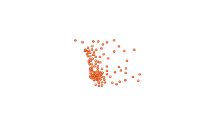

In [30]:
#get feature layer containing updated data for maps associated with the CUMULATIVE COVID-19 dashboard
layer2 = gis.content.get(feature_layer2)
layer2

In [31]:
#List all the current fields in the layer so you can use one as a field template.
cum_covid_lyr = layer2.layers[0]
cum_covid_lyr

<FeatureLayer url:"https://services1.arcgis.com/SIYkiqjmENweC50g/arcgis/rest/services/sd_zip_cumulative_covid_data/FeatureServer/0">

In [32]:
#reformat date for use in appending: append_source = column name in csv, append_field = column name in feature layer, append_alias = column alias
split = most_recent_date.split('/')

append_source = ''

for i in range(len(split)):
    if(split[i][0] is '0'):
        split[i] = split[i][1:]
    if(i == 0):
        append_source += split[i]
    elif(i == (len(split)-1)): 
        append_source += '_' + split[i]
    else:
        append_source += '_' + split[i]

append_field = 'F' + append_source + '20'
append_alias = append_source.replace('_','/') + '20'

In [33]:
#Create a dictionary from a deep copy of a field in the feature layer, and update the values of this dictionary to reflect a new field.
new_field = dict(deepcopy(cum_covid_lyr.properties.fields[5]))
new_field['name'] = append_field
new_field['alias'] = append_alias
new_field['length'] = "10"
print(new_field)

#Update feature layer definition with the new field using the add_to_definition() method.
field_list = [new_field]
cum_covid_lyr.manager.add_to_definition({"fields":field_list})

{'name': 'F8_16_2020', 'type': 'esriFieldTypeDouble', 'actualType': 'float', 'alias': '8/16/2020', 'sqlType': 'sqlTypeFloat', 'nullable': True, 'editable': True, 'domain': None, 'defaultValue': None, 'length': '10'}


{'success': True}

In [34]:
#only need to add index to 'Zipcode' once - cell kept for reference

#Add a unique index to the new attribute field, needed to append
#flds = [f.fields.lower() for f in cum_covid_lyr.properties.indexes if f.isUnique]

#for fld in cum_covid_lyr.properties.fields:
#    if fld.name.lower() in flds:
#        print(f"{fld.name:30}{fld.type:25}isUnique")
#    else:
#        print(f"{fld.name:30}{fld.type:25}")

#Create a copy of one index, then edit it to reflect values for a new index. Then add that to the layer definition.
#name_idx = dict(deepcopy(cum_covid_lyr.properties['indexes'][0]))
#name_idx['name'] = 'Zipcode'
#name_idx['fields'] = 'Zipcode'
#name_idx['isUnique'] = True
#name_idx['description'] = 'index_name'
#name_idx

#index_list = [name_idx]
#cum_covid_lyr.manager.add_to_definition({"indexes":index_list})

#Verify the index was added
#layer2 = gis.content.get(feature_layer2)
#layer2

#flds = [f.fields.lower() for f in cum_covid_lyr.properties.indexes if f.isUnique]

#for fld in cum_covid_lyr.properties.fields:
#    if fld.name.lower() in flds:
#        print(f"{fld.name:30}{fld.type:25}isUnique")
#    else:
#        print(f"{fld.name:30}{fld.type:25}")      

In [35]:
#update csv item to contain new date column for addition to the feature layer
append_df2 = wide_df[['Zipcode', '{}'.format(most_recent_date)]]
append_df2 = append_df2.rename(columns = {'{}'.format(most_recent_date): '{}'.format(append_source)})

append_df2 = append_df2[append_df2.index.notnull()]
append_df2 = append_df2.fillna(0)
append_df2['{}'.format(append_source)] = append_df2['{}'.format(append_source)].astype(int)
append_df2.to_csv(append_csv_path)


In [36]:
append_csv_item = gis.content.get(append_csv)
#append_csv_item
append_csv_item.update({}, append_csv_path)

#get *append_csv_info* when appending a new column for source_info
append_csv_info = gis.content.analyze(item=append_csv, file_type='csv', location_type='none')
#append_csv_info

In [37]:
#append new date column to feature layer from csv item
cum_covid_lyr.append(item_id= append_csv,
                      upload_format = 'csv',
                      field_mappings = [{"name":"{}".format(append_field), "source":"{}".format(append_source)},
                                        {"name":"Zipcode", "source":"Zipcode"}],
                      source_info = append_csv_info['publishParameters'],
                      update_geometry=False,
                      append_fields=["{}".format(append_field), "Zipcode"],
                      skip_inserts=True,
                      upsert_matching_field="Zipcode")

True

### MODIFY CONFIRMED CASES WEB MAP SYMBOLOGY

In [38]:
#confirmed cases map

#get map data
cc_data = get_map(cc)

#set symbol to new date field, adjust max symbology
cc_data['operationalLayers'][1]['layerDefinition']['drawingInfo']['renderer']['field'] = append_field
cc_data['operationalLayers'][1]['layerDefinition']['drawingInfo']['renderer']['visualVariables'][0]['field'] = append_field
cc_data['operationalLayers'][1]['layerDefinition']['drawingInfo']['renderer']['visualVariables'][0]['maxDataValue'] = max_confirmed.item()
cc_data['operationalLayers'][1]['layerDefinition']['drawingInfo']['renderer']['authoringInfo']['visualVariables'][0]['maxSliderValue'] = max_confirmed.item()

#set labeling to new date field
cc_data['operationalLayers'][1]['layerDefinition']['drawingInfo']['labelingInfo'][0]['labelExpressionInfo']['expression'] = '$feature["{}"]'.format(append_field)
cc_data['operationalLayers'][1]['layerDefinition']['drawingInfo']['labelingInfo'][0]['labelExpressionInfo']['value'] = ('{' + append_field + '}')
cc_data['operationalLayers'][1]['layerDefinition']['drawingInfo']['labelingInfo'][0]['fieldInfos'][0]['fieldName'] = append_field

#set filter to new date
cc_data['operationalLayers'][1]['layerDefinition']['definitionExpression'] = ('{} > 0'.format(append_field))

#adjust last date in popup
new_date = cc_data['operationalLayers'][1]['popupInfo']['fieldInfos'][-1].copy()
new_date['fieldName'] = append_field
new_date['label'] = append_alias
cc_data['operationalLayers'][1]['popupInfo']['fieldInfos'][-1]['visible'] = False
cc_data['operationalLayers'][1]['popupInfo']['fieldInfos'].append(new_date)
#cc_data['operationalLayers'][1]['popupInfo']['fieldInfos']

#add new date to popup chart
popup_chart=cc_data['operationalLayers'][1]['popupInfo']['mediaInfos'][0]['value']['fields']
popup_chart.append(append_field)
cc_data['operationalLayers'][1]['popupInfo']['mediaInfos'][0]['value']['fields'] = popup_chart

#update map to save changes
cc_update = update_map(cc, cc_data)
cc_update

<Item title:"SD-COVID-Zipcodes_Main_Copy" type:Web Map owner:jembury8568_SDSUGeo>


True

# VIEW UPDATED DASHBOARDS

In [39]:
#Open heatmaps dashboard in browser
webbrowser.open(heatmap_dash, new=2)

#Open rates of change dashboard in browser
webbrowser.open(rates_dash, new=2)

#open cumulative/growth chart map
webbrowser.open(cumulative_dash, new=2)

#County-wide information snapshot
print("Date: {}, Number of Zip Codes: {}, Total Cases: {}, Daily Increase: {}".format(most_recent_date, len(df), sum_confirmed, sum_daily))
#df.head()

Date: 08/16/20, Number of Zip Codes: 80, Total Cases: 33728, Daily Increase: 275
